<a href="https://colab.research.google.com/github/Shosh3sb/computer_vision_512/blob/main/CV4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**First, we import all the libraries that we will be using in this task.**

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')


---
## 1. **Semantic segmentation**<a class="anchor" id="1"></a>

### 1.1. **Load data set.**<a class="anchor" id="1.1"></a>

In [ ]:
!wget --no-check-certificate https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
!wget --no-check-certificate https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz


--2023-04-12 02:39:45--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2023-04-12 02:39:45--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  22.2MB/s    in 36s     

2023-04-12 02:40:21 (21.2 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2023-04-12 02:40:21--  https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.

In [ ]:
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

In [ ]:
import os

images_dir="/content/images"
masks_dir="/content/annotations/trimaps"

images_path=sorted([os.path.join(images_dir,name) for name in os.listdir(images_dir) if name.endswith(".jpg")])
masks_path=sorted([os.path.join(masks_dir,name) for name in os.listdir(masks_dir) if name.endswith(".png") and not name.startswith(".")])

print("number images= ",len(images_path)," : ","number masks= ",len(masks_path))



number images=  7390  :  number masks=  7390


In [ ]:
def load_instens(image_path,mask_path,size_image):
  input_image=tf.keras.utils.img_to_array(tf.keras.utils.load_img(path=image_path
                                                                  ,target_size=size_image
                                                                  ))
  input_mask = tf.keras.utils.img_to_array(tf.keras.utils.load_img( path=mask_path
                                                                   ,target_size=size_image
                                                                   ,color_mode='grayscale'
                                                                   ))
  return input_image,input_mask


In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask =input_mask.astype("uint8")-1
  return input_image, input_mask

In [ ]:
size_image=(128,128)
num_instans=len(images_path)
input_images=np.zeros((num_instans,)+size_image+(3,),dtype="float32")
input_masks=np.zeros((num_instans,)+size_image+(1,),dtype="uint8")

for index in range(num_instans):
  input_images[index],input_masks[index]=load_instens(images_path[index],masks_path[index],size_image)
  input_images[index],input_masks[index]=normalize(input_images[index],input_masks[index])

print("shape input images= ",input_images.shape," : ","shape input masks= ",input_masks.shape)

shape input images=  (7390, 128, 128, 3)  :  shape input masks=  (7390, 128, 128, 1)


---
### 1.2. **Convert labels to  category dog/cat.**<a class="anchor" id="1.2"></a>

In [ ]:
def convertlables(paths):
  lables=[]
  for path in paths:
    name=path.split('/')[-1]
    if name[0].isupper():
      lables.append(0)
    else:
      lables.append(1)
  return np.array(lables)


In [ ]:
convertlables(images_path)

array([0, 0, 0, ..., 1, 1, 1])

---
### 1.3. **Visualize segmentation mask.**<a class="anchor" id="1.3"></a>

In [ ]:
def visualize(display_list,titles):
  plt.figure(figsize=(7, 7))
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()


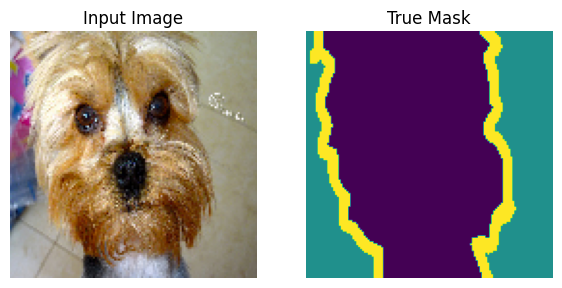

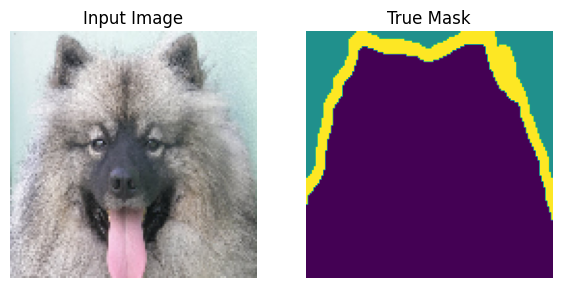

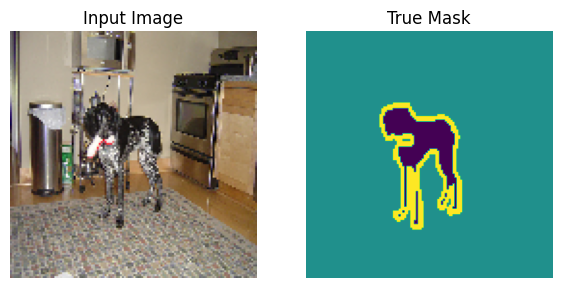

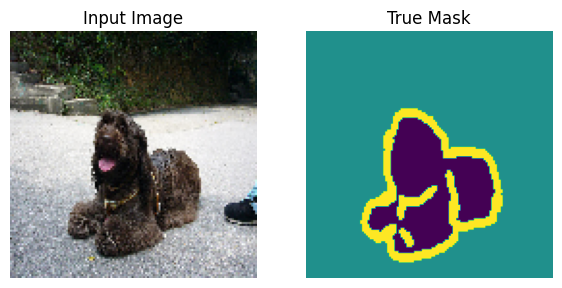

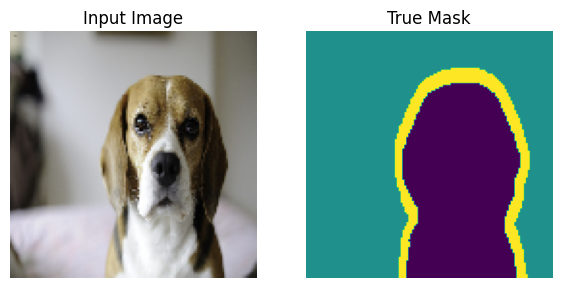

In [ ]:
indeces=np.random.randint(len(input_images), size=(5))
titles=['Input Image', 'True Mask']
for index in indeces:
  visualize([input_images[index],input_masks[index][:,:,0]],titles=titles)

---
### 1.4. **Split the dataset to training, validation, and test subsets.**<a class="anchor" id="1.4"></a>

In [ ]:
import random

random.Random(42).shuffle(input_images)
random.Random(42).shuffle(input_masks)


val_rate=0.30
num_val=int(len(input_images)*val_rate)

train_input_images=input_images[:-num_val]
train_input_masks=input_masks[:-num_val]

val_input_images=input_images[-num_val:]
val_input_masks=input_masks[-num_val:]

test_rate=0.10
num_test=int(len(val_input_images)*test_rate)
test_input_images=val_input_images[-num_test:]
test_input_masks=val_input_masks[-num_test:]


val_input_images=val_input_images[:-num_test]
val_input_masks=val_input_masks[:-num_test]

print("size training= ",len(train_input_images)," : ","size validation= ",
      len(val_input_images)," : ","size testing= ",len(test_input_images))

size training=  5173  :  size validation=  1996  :  size testing=  221


---
### 1.5. **Convolutional neural network without skip connections.**<a class="anchor" id="1.5"></a>

**A function that create model.**

In [ ]:
def create_model(input_size,num_class):
  inputs=keras.Input(shape=input_size)
  x=layers.Rescaling(1./255)(inputs)

  #encoder
  x=layers.Conv2D(64,3,strides=2,activation="relu",padding="same")(x)
  x=layers.Conv2D(64,3,activation="relu",padding="same")(x)
  x=layers.Conv2D(128,3,strides=2,activation="relu",padding="same")(x)
  x=layers.Conv2D(128,3,activation="relu",padding="same")(x)
  x=layers.Conv2D(256,3,strides=2,activation="relu",padding="same")(x)
  x=layers.Conv2D(256,3,activation="relu",padding="same")(x)

  #decoder
  x=layers.Conv2DTranspose(256,3,activation="relu",padding="same")(x)
  x=layers.Conv2DTranspose(256,3,strides=2,activation="relu",padding="same")(x)
  x=layers.Conv2DTranspose(128,3,activation="relu",padding="same")(x)
  x=layers.Conv2DTranspose(128,3,strides=2,activation="relu",padding="same")(x)
  x=layers.Conv2DTranspose(64,3,activation="relu",padding="same")(x)
  x=layers.Conv2DTranspose(64,3,strides=2,activation="relu",padding="same")(x)

  outputs=layers.Conv2D(num_class,3,activation="softmax",padding="same")(x)
  model=keras.Model(inputs,outputs)

  return model


In [ ]:
model=create_model(input_size=size_image+(3,),num_class=3)

**View a summary of the structure of the CNN model.**

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 256)       295168

**View the structure of the CNN model.**

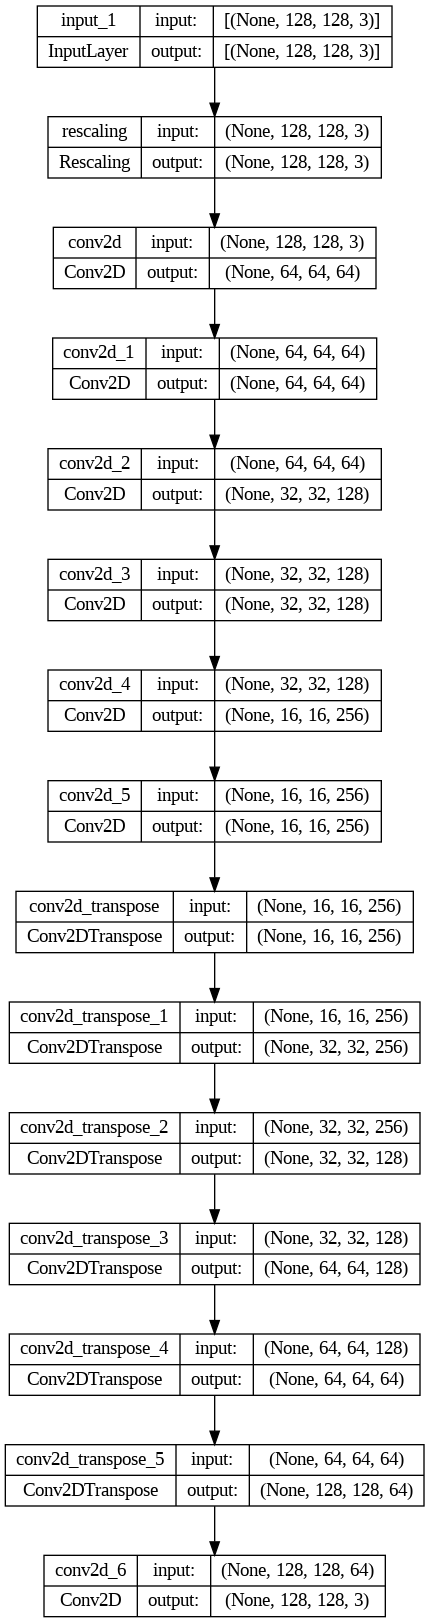

In [ ]:
keras.utils.plot_model(model,'Cnn_model_without_skip_connections.png',show_shapes=True)

**Compile and train model.**

In [ ]:
model.compile(optimizer='rmsprop',loss=keras.losses.sparse_categorical_crossentropy,metrics=["accuracy"])
callbacks=[keras.callbacks.ModelCheckpoint("ofxed_segment__model_without_skip_connections.keras",save_best_only=True)]
history=model.fit(
                  x=train_input_images,
                  y=train_input_masks,
                  batch_size=64,
                  epochs=50,
                  callbacks=callbacks,
                  validation_data=(val_input_images,val_input_masks)
                  )


Epoch 1/50
81/81 [==============================] - 49s 352ms/step - loss: 0.9591 - accuracy: 0.5585 - val_loss: 0.8786 - val_accuracy: 0.5777
Epoch 2/50
81/81 [==============================] - 20s 248ms/step - loss: 0.8760 - accuracy: 0.5631 - val_loss: 0.8286 - val_accuracy: 0.5941
Epoch 3/50
81/81 [==============================] - 20s 252ms/step - loss: 0.8346 - accuracy: 0.6350 - val_loss: 0.7899 - val_accuracy: 0.6815
Epoch 4/50
81/81 [==============================] - 20s 249ms/step - loss: 0.8074 - accuracy: 0.6724 - val_loss: 0.7812 - val_accuracy: 0.6859
Epoch 5/50
81/81 [==============================] - 20s 247ms/step - loss: 0.7950 - accuracy: 0.6817 - val_loss: 0.7844 - val_accuracy: 0.6884
Epoch 6/50
81/81 [==============================] - 23s 279ms/step - loss: 0.7940 - accuracy: 0.6803 - val_loss: 0.7685 - val_accuracy: 0.6908
Epoch 7/50
81/81 [==============================] - 23s 279ms/step - loss: 0.7824 - accuracy: 0.6835 - val_loss: 0.7931 - val_accuracy: 0.6824

**Plot training and validation loss**

In [ ]:
def performance_model_plot(history,isaccuarcy=True):
    loss_values = history.history['loss']
    val_loss_values = history.history['val_loss']
    epochs = range(1, len(loss_values) + 1)

    plt.figure(figsize=(15, 3))

    # Plot the loss vs Epochs
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_values)
    plt.plot(epochs, val_loss_values)
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Training Loss','Validation Loss'])

    # Plot the accuracy vs Epochs
    if isaccuarcy:
      accuracy_values = history.history['accuracy']
      val_accuracy_values = history.history['val_accuracy']
      plt.subplot(1, 2, 2)
      plt.plot(epochs, accuracy_values)
      plt.plot(epochs, val_accuracy_values)
      plt.title('Training & Validation accuracy')
      plt.xlabel('Epochs')
      plt.ylabel('accuracy')
      plt.legend(['Training accuracy','Validation accuracy'])

    plt.show()


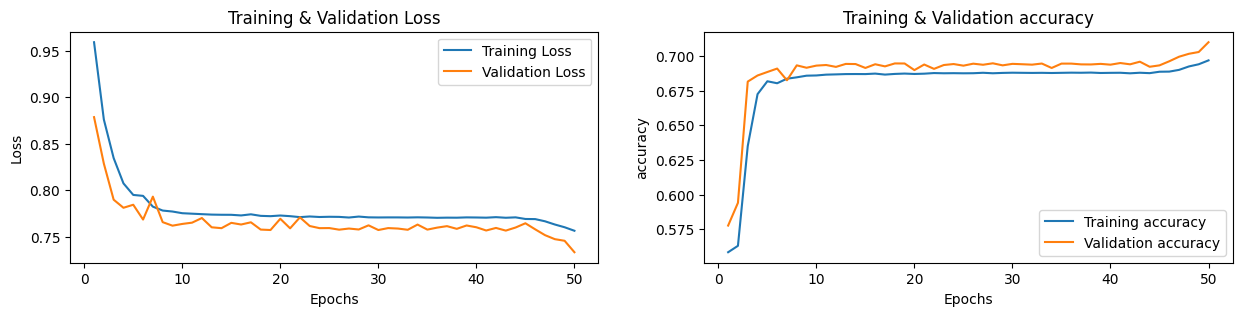

In [ ]:
performance_model_plot(history)

**Evaluating the model.**

In [ ]:
best_model_notskip=keras.models.load_model("ofxed_segment__model_without_skip_connections.keras")

In [ ]:
score = best_model_notskip.evaluate(test_input_images, test_input_masks,verbose=1)
print('score:', score)

7/7 [==============================] - 3s 258ms/step - loss: 0.7309 - accuracy: 0.7122
score: [0.7308692336082458, 0.7122159004211426]


**Visualize some inference results.**

In [ ]:
def predict(model,input_images,isvisualize):
    titles = ['Input Image','Predicted Mask']
    masks=[]
    for img in input_images:
        msk=model.predict(np.expand_dims(img,0))[0]
        msk=np.argmax(msk,axis=-1)
        masks.append(msk)
        if isvisualize:
          visualize([keras.utils.array_to_img(img),msk],titles)
    return masks

1/1 [==============================] - 0s 25ms/step


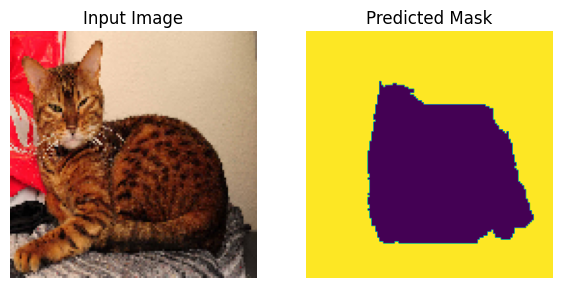

1/1 [==============================] - 0s 18ms/step


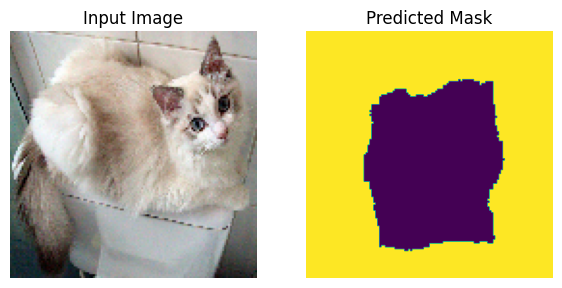

1/1 [==============================] - 0s 20ms/step


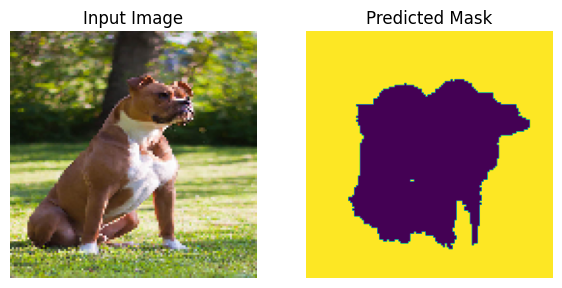

1/1 [==============================] - 0s 33ms/step


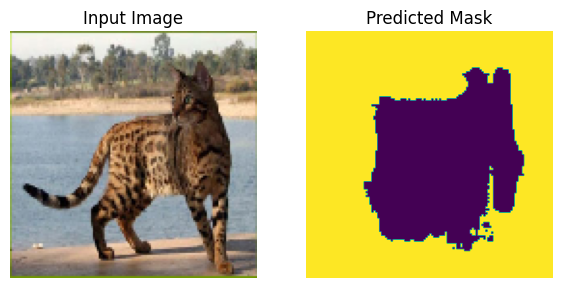

1/1 [==============================] - 0s 21ms/step


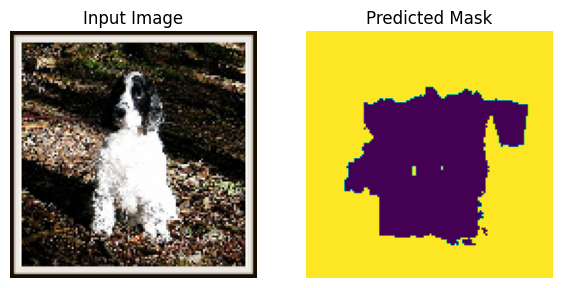

In [ ]:
masks_pred=predict(best_model_notskip,val_input_images[:5],isvisualize=True)

---
### 1.6. **Convolutional neural network with skip connections.**<a class="anchor" id="1.6"></a>

**A functions that create model skip connections.**

In [ ]:
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merging import add,concatenate


#..........................................................

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x


#..........................................................

def get_unet(input_img,num_class, n_filters = 16, dropout = 0.1, batchnorm = True):

    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(num_class, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

#..........................................................


In [ ]:
im_height,im_width=128,128
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img,num_class=3, n_filters=16, dropout=0.05, batchnorm=True)


**View a summary of the structure of the CNN skip connections model.**

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 128, 128, 16  448         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 128, 128, 16  64         ['conv2d_8[0][0]']               
 rmalization)                   )                                                           

**View the structure of the CNN skip connections model.**

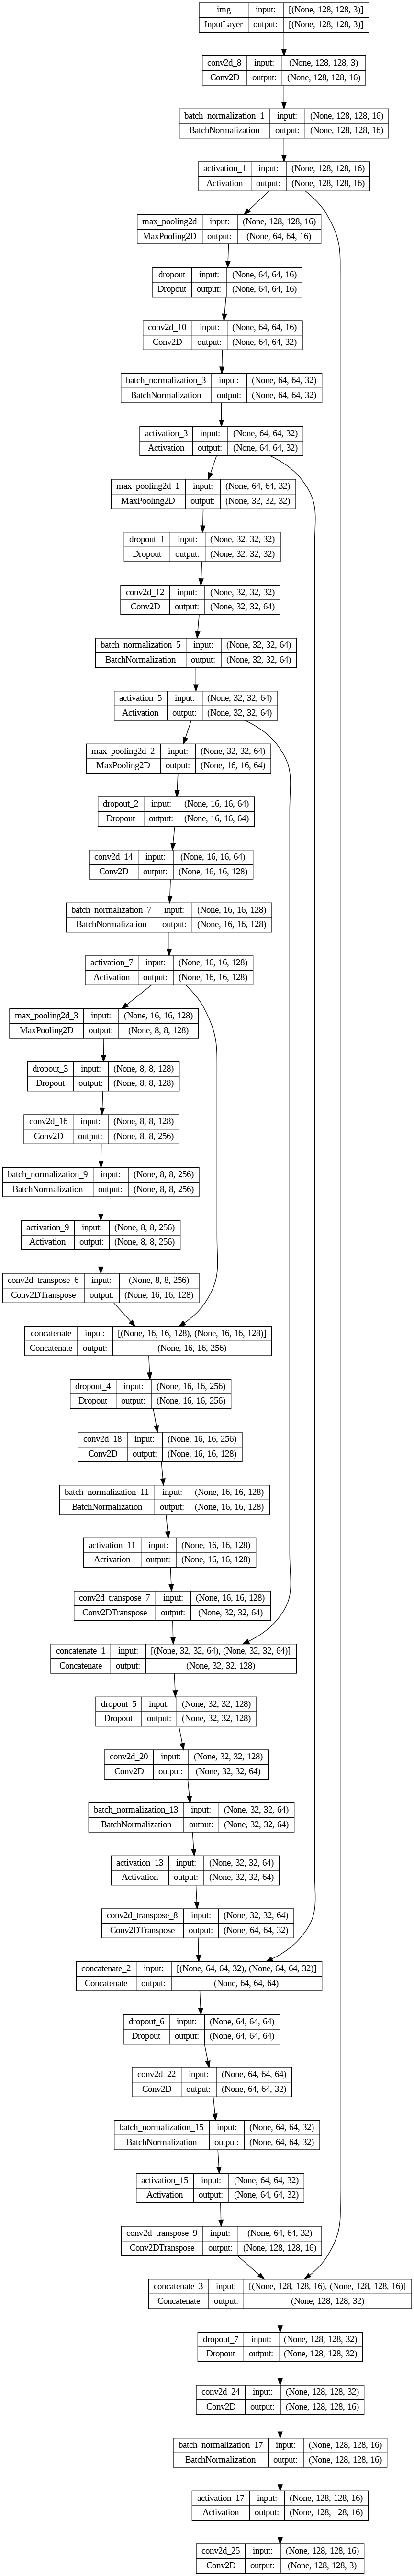

In [ ]:
keras.utils.plot_model(model,'Cnn_model_skip_connections.png',show_shapes=True)

**Compile and train model.**

In [ ]:
model.compile(optimizer='rmsprop',loss=keras.losses.sparse_categorical_crossentropy,metrics=["accuracy"])

In [ ]:
callbacks=[keras.callbacks.ModelCheckpoint("ofxed_segment__model_skip_connections.keras",save_best_only=True)]
history=model.fit(
                  x=train_input_images,
                  y=train_input_masks,
                  batch_size=64,
                  epochs=30,
                  callbacks=callbacks,
                  validation_data=(val_input_images,val_input_masks)
                  )


Epoch 1/30
81/81 [==============================] - 27s 221ms/step - loss: 0.7552 - accuracy: 0.6775 - val_loss: 1.0413 - val_accuracy: 0.6169
Epoch 2/30
81/81 [==============================] - 13s 161ms/step - loss: 0.5864 - accuracy: 0.7625 - val_loss: 1.2122 - val_accuracy: 0.6486
Epoch 3/30
81/81 [==============================] - 13s 162ms/step - loss: 0.5219 - accuracy: 0.7913 - val_loss: 0.7135 - val_accuracy: 0.7529
Epoch 4/30
81/81 [==============================] - 13s 162ms/step - loss: 0.4806 - accuracy: 0.8091 - val_loss: 0.6160 - val_accuracy: 0.7768
Epoch 5/30
81/81 [==============================] - 13s 162ms/step - loss: 0.4506 - accuracy: 0.8219 - val_loss: 0.5341 - val_accuracy: 0.8002
Epoch 6/30
81/81 [==============================] - 13s 162ms/step - loss: 0.4173 - accuracy: 0.8356 - val_loss: 0.5763 - val_accuracy: 0.7939
Epoch 7/30
81/81 [==============================] - 13s 163ms/step - loss: 0.3990 - accuracy: 0.8429 - val_loss: 0.4338 - val_accuracy: 0.8341

**Plot training and validation loss**

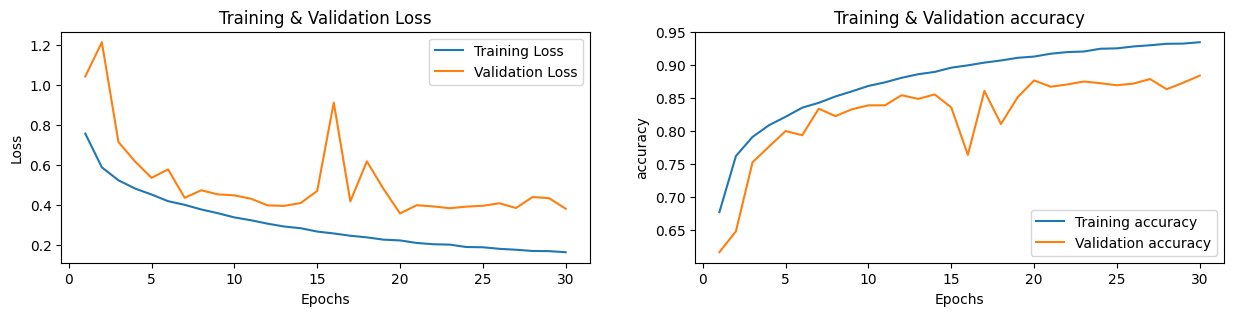

In [ ]:
performance_model_plot(history)

**Evaluating the model.**

In [ ]:
best_model_skip=keras.models.load_model("ofxed_segment__model_skip_connections.keras")

In [ ]:
score = best_model_skip.evaluate(test_input_images, test_input_masks,verbose=1)
print('score:', score)

7/7 [==============================] - 2s 138ms/step - loss: 0.3372 - accuracy: 0.8826
score: [0.3371557891368866, 0.8826169371604919]


**Visualize some inference results.**

1/1 [==============================] - 1s 628ms/step


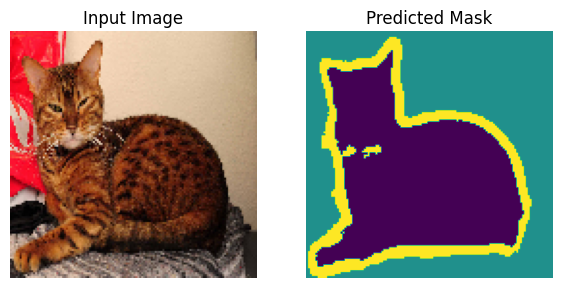

1/1 [==============================] - 0s 21ms/step


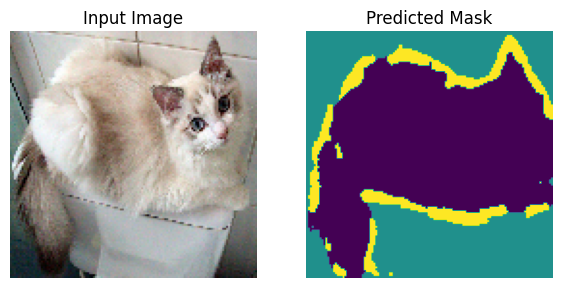

1/1 [==============================] - 0s 25ms/step


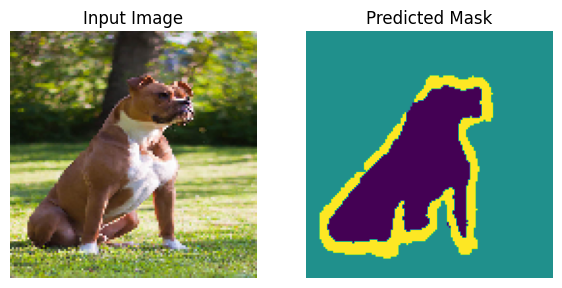

1/1 [==============================] - 0s 26ms/step


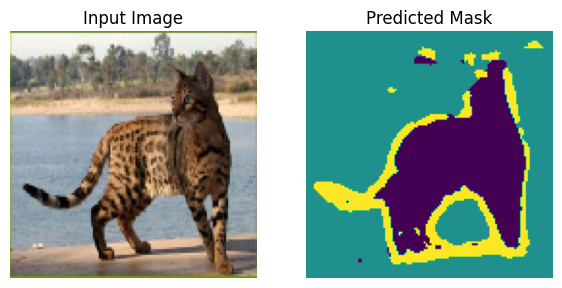

1/1 [==============================] - 0s 20ms/step


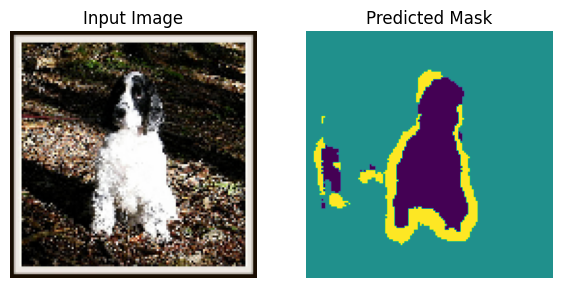

In [ ]:
masks_pred=predict(best_model_skip,val_input_images[:5],isvisualize=True)

---
### 1.7. **Pretrained TFSegformerForSemanticSegmentation model .**<a class="anchor" id="1.7"></a>

**Install transformers.**

In [ ]:
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 27.1 MB/s eta 0:00:00


In [ ]:
from transformers import TFSegformerForSemanticSegmentation

**Preprocessing dataset.**

In [ ]:
size_image=(512,512)

def data_preprocessing(image,mask):
  image=tf.image.resize(image, size_image)
  mask=tf.image.resize(mask, size_image,method="bilinear")
  return {"pixel_values": tf.transpose(image, (2, 0, 1)), "labels": tf.squeeze(mask)}


In [ ]:
data_train =tf.data.Dataset.from_tensor_slices((train_input_images, train_input_masks))
data_val   =tf.data.Dataset.from_tensor_slices((val_input_images, val_input_masks))

batch_size = 4

train_ds = (
             data_train
            .cache()
            .shuffle(batch_size * 10)
            .map(data_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE)
            )

val_ds = (
           data_val
          .map(data_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(batch_size)
          .prefetch(tf.data.AUTOTUNE)
          )



In [ ]:
print(train_ds.element_spec)
print(val_ds.element_spec)

{'pixel_values': TensorSpec(shape=(None, 3, 512, 512), dtype=tf.float32, name=None), 'labels': TensorSpec(shape=(None, 512, 512), dtype=tf.float32, name=None)}
{'pixel_values': TensorSpec(shape=(None, 3, 512, 512), dtype=tf.float32, name=None), 'labels': TensorSpec(shape=(None, 512, 512), dtype=tf.float32, name=None)}


**Load a pretrained SegFormer checkpoint.**

In [ ]:
model_checkpoint = "nvidia/mit-b0"
id2label = {0: "outer", 1: "inner", 2: "border"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)
model = TFSegformerForSemanticSegmentation.from_pretrained(
                                                            model_checkpoint,
                                                            num_labels=num_labels,
                                                            id2label=id2label,
                                                            label2id=label2id,
                                                            ignore_mismatched_sizes=True,
                                                            )

Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**View a summary.**

In [ ]:
model.summary()

Model: "tf_segformer_for_semantic_segmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMainL  multiple                 3319392   
 ayer)                                                           
                                                                 
 decode_head (TFSegformerDec  multiple                 396035    
 odeHead)                                                        
                                                                 
Total params: 3,715,427
Trainable params: 3,714,915
Non-trainable params: 512
_________________________________________________________________


**Compile and train model.**

In [ ]:
lr = 0.00006
optimizer = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
history = model.fit(
                    train_ds,
                    validation_data=val_ds,
                    epochs=10
                    )

Epoch 1/10
1294/1294 [==============================] - 438s 313ms/step - loss: 0.3137 - val_loss: 0.2375
Epoch 2/10
1294/1294 [==============================] - 395s 305ms/step - loss: 0.2287 - val_loss: 0.2190
Epoch 3/10
1294/1294 [==============================] - 433s 335ms/step - loss: 0.1985 - val_loss: 0.2105
Epoch 4/10
1294/1294 [==============================] - 434s 335ms/step - loss: 0.1847 - val_loss: 0.2056
Epoch 5/10
1294/1294 [==============================] - 433s 335ms/step - loss: 0.1760 - val_loss: 0.2013
Epoch 6/10
1294/1294 [==============================] - 432s 334ms/step - loss: 0.1663 - val_loss: 0.1996
Epoch 7/10
1294/1294 [==============================] - 432s 334ms/step - loss: 0.1609 - val_loss: 0.1987
Epoch 8/10
1294/1294 [==============================] - 433s 334ms/step - loss: 0.1545 - val_loss: 0.1984
Epoch 9/10
1294/1294 [==============================] - 432s 334ms/step - loss: 0.1515 - val_loss: 0.1903
Epoch 10/10
1294/1294 [=======================

**Plot training and validation loss.**

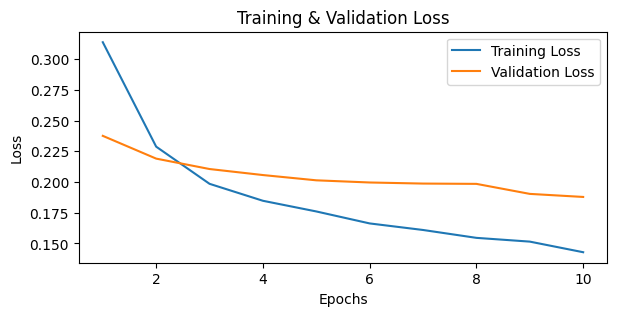

In [ ]:
performance_model_plot(history,False)

**Evaluating the model.**

In [ ]:
score = model.evaluate(val_ds)
print('score:', score)

499/499 [==============================] - 45s 89ms/step - loss: 0.1878
score: 0.18780823051929474


**Visualize some inference results.**

In [ ]:
def predict_segmt(model,ds,num,isvisualize):
    titles = ['Input Image','Predicted Mask']
    masks=[]
    for simple in ds.take(num):
      image=simple['pixel_values']
      pre_mask=model.predict(image).logits
      pre_mask=tf.math.argmax(pre_mask,axis=1)[0,:,:]
      image=tf.transpose(image,(0,2,3,1))[0,:,:,:]

      if isvisualize:
        visualize([keras.utils.array_to_img(image),pre_mask],titles)
      masks.append(pre_mask)

    return masks



1/1 [==============================] - 0s 115ms/step


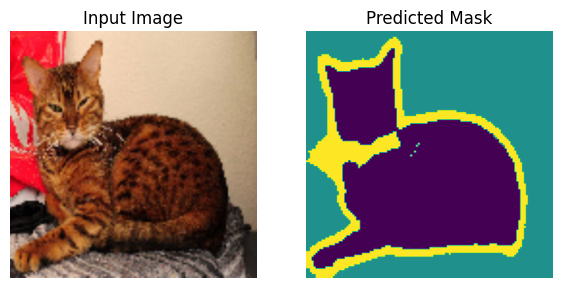

1/1 [==============================] - 0s 97ms/step


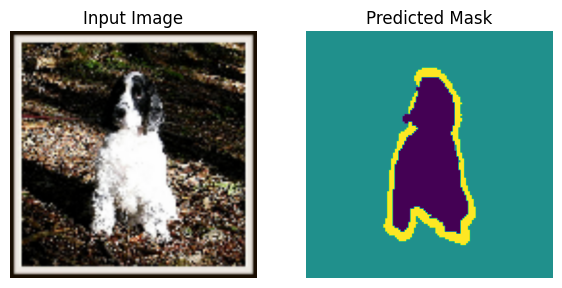

1/1 [==============================] - 0s 98ms/step


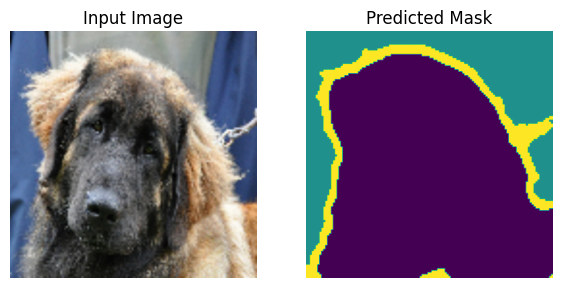

1/1 [==============================] - 0s 97ms/step


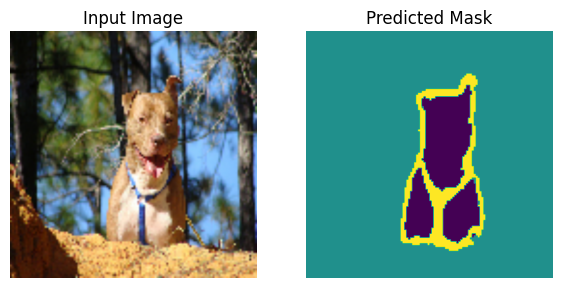

1/1 [==============================] - 0s 104ms/step


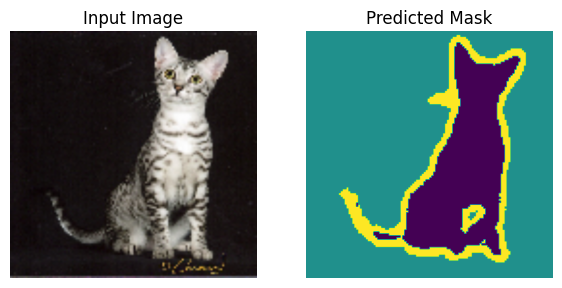

In [ ]:
masks_pred=predict_segmt(model,val_ds,num=5,isvisualize=True)

---
## 2. **Object detection**<a class="anchor" id="2"></a>


### 2.1. **Define a bounding box.**<a class="anchor" id="2.1"></a>

In [ ]:
import os

images_dir="/content/images"
ann_dir = "/content/annotations/xmls"


ann_paths = sorted(os.listdir(ann_dir))
image_paths = [str(img[:-3]+'jpg') for img in ann_paths]

ann_paths=[os.path.join(ann_dir,name) for name in ann_paths]
image_paths=[os.path.join(images_dir,name) for name in image_paths if name.endswith(".jpg")]


print("number images= ",len(image_paths)," : ","number bounding box= ",len(ann_paths))



number images=  3686  :  number bounding box=  3686


In [ ]:
import bs4 as bs
import cv2


def data_gen(image_paths,ann_paths,size_image):
  boxs = []
  images=[]
  for i in range(len(ann_paths)):
    with open(ann_paths[i],'r') as f:
      fstr = f.read()

    soup = bs.BeautifulSoup(fstr)
    h = float(soup.height.text)
    w = float(soup.width.text)
    xmin = int(soup.xmin.text)/w
    ymin = int(soup.ymin.text)/h
    xmax = int(soup.xmax.text)/w
    ymax = int(soup.ymax.text)/h
    boxs.append(np.array([xmin,ymin,xmax,ymax]))
    image=tf.keras.utils.img_to_array(tf.keras.utils.load_img(path=image_paths[i]
                                                                  ,target_size=size_image
                                                                  ))
    image = tf.cast(image, tf.float32) / 255.0
    images.append(image)

  return np.array(images),np.array(boxs)


In [ ]:
size_image=(128,128)
images_ds, boxs_ds = data_gen(image_paths,ann_paths,size_image)
print("shape input images= ",images_ds.shape," : ","shape input bouinding box= ",boxs_ds.shape)

shape input images=  (3686, 128, 128, 3)  :  shape input bouinding box=  (3686, 4)


In [ ]:
def showboindingbox(image,box):
  h,w,_=image.shape
  box=np.array([box[0]*w,box[1]*h,box[2]*w,box[3]*h],dtype="int16")
  plt.figure(figsize=(3, 3))
  image=(image*255).astype(np.int16)
  imgbox = cv2.rectangle(image,(box[0],box[1]),(box[2],box[3]),(255,0,0),1)
  plt.imshow(imgbox)
  plt.axis('off')
  plt.show()



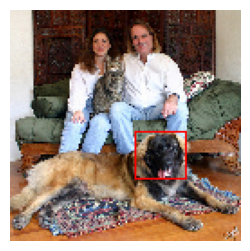

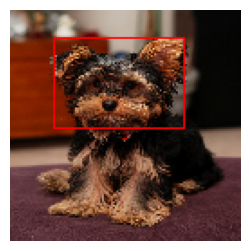

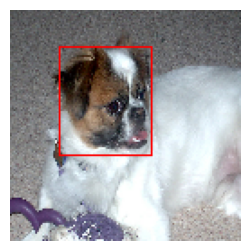

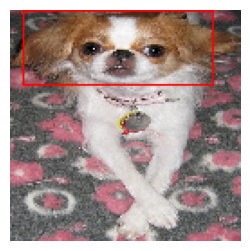

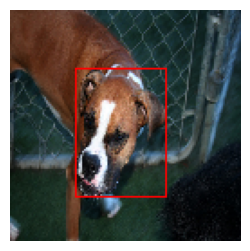

In [ ]:
indeces=np.random.randint(len(images_ds), size=(5))
for index in indeces:
  showboindingbox(images_ds[index],boxs_ds[index])

---
### 2.2. **YOLO3 model.**<a class="anchor" id="2.2"></a>

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2023-04-12 04:47:33--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  92.1MB/s    in 2.6s    

2023-04-12 04:47:35 (92.1 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 35.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.1/301.1 kB 35.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.8/377.8 kB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 71.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Prep

In [ ]:
import yolo3_one_file_to_detect_them_all_modif as yolo

**Convert the weights to a Keras compatible file .h5 .**

In [ ]:
# define the model
model = yolo.make_yolov3_model()
# load the model weights
weight_reader = yolo.WeightReader('/content/yolov3.weights')
# set the model weights into the model
weight_reader.load_weights(model)
# save the model to file
model.save('yolov3.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

loading weights of convolution #81
no convolution #82
no convolution #83
loading weights of convolution #84
no convolution #85
no convolution #86
loading weights of convolution #87
loading weights of convolution #88
loading weights of convolution #89
loading weights of convolution #90
loading weights of convolution #91
loading weights of convolution #92
loading weights of convolution #93
no convolution #94
no convolution #95
loading weights of convolution #96
no convolution #97
no convolution #98
loading weights of convolution #99
loading weights of convolution #100
loading weights of convolution #101
loading weights of convolution #102
loading weights of convolution #103
loading weights of convolution #104
loading weights of convolution #105


**Load the model in a program && Apply the model to predict results.**

In [ ]:
from keras.models import load_model
model_yolo = load_model('/content/yolov3.h5')

1/1 [==============================] - 0s 186ms/step
dog: 99.90217685699463%


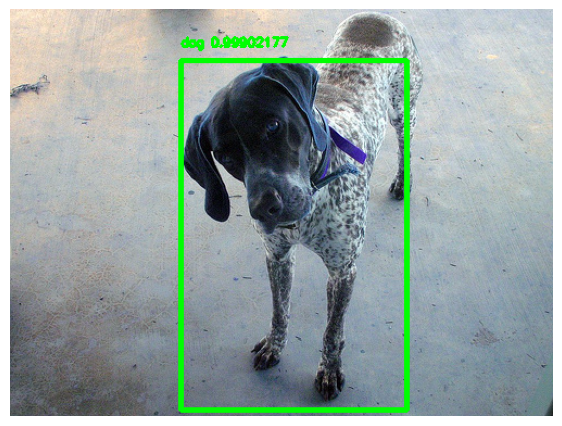

1/1 [==============================] - 0s 46ms/step
bear: 94.13685202598572%


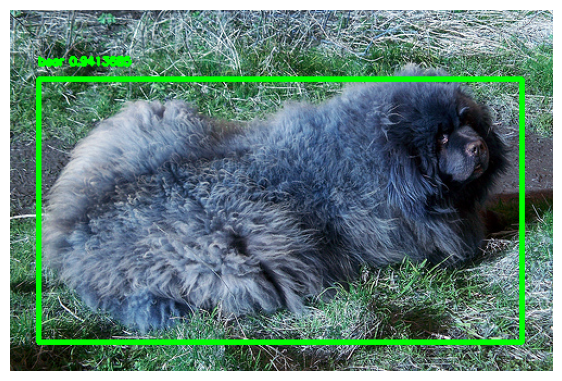

1/1 [==============================] - 0s 35ms/step
cat: 90.19179344177246%


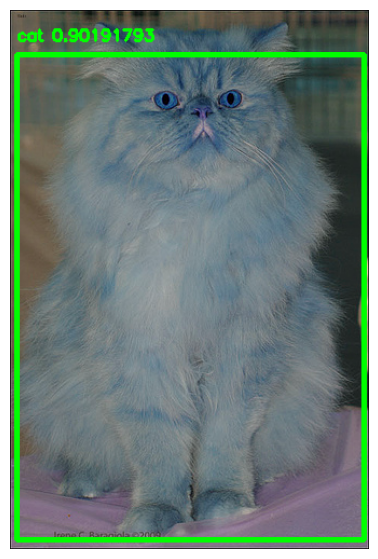

In [ ]:
indeces=np.random.randint(len(image_paths), size=(3))
for index in indeces:
  image=yolo._main_(args=[image_paths[index]],yolov3=model_yolo,ismain=False)
  plt.figure(figsize=(7, 7))
  plt.imshow(image)
  plt.axis('off')
  plt.show()


**Evaluate the performance of the model on the cats/dogs dataset using the known labels.**

**`Load Gt_label.txt and Pred_label.txt files`**

In [ ]:
import pandas as pd
namescol=['img_base','x_min','y_min','x_max','y_max','class_id','confidence']
gt_lb=pd.read_csv('/content/gt_label.txt',header=None,names=namescol[:-1],sep="\s|,")
pred_lb=pd.read_csv('/content/pred_label.txt',header=None,names=namescol,sep="\s|,")


In [ ]:
gt_lb.head()

img_base  x_min  y_min  x_max  y_max  class_id
0  Abyssinian_201     89     81    299    224         0
1  Abyssinian_202    102     12    237    208         0
2  Abyssinian_204      7     34    201    299         0
3  Abyssinian_205      0      0    183    299         0
4  Abyssinian_206     20      9    299    278         0

In [ ]:
pred_lb.head()

img_base  x_min  y_min  x_max  y_max  class_id  confidence
0  Abyssinian_201     84     84    298    218         0    0.977127
1  Abyssinian_202    106     22    235    202         0    0.990660
2  Abyssinian_204     54     37    205    297         0    0.972732
3  Abyssinian_205      3      6    161    298         0    0.874382
4  Abyssinian_206     25     17    280    265         0    0.993073

In [ ]:
gt_lb.shape,pred_lb.shape

((3662, 6), (3484, 7))

**MAPs calculations.**

In [ ]:
!pip install mapcalc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from mapcalc import calculate_map, calculate_map_range

In [ ]:
truth=[]

for index, row in gt_lb.iterrows():
  ground_truth={}
  result_dict={}
  ground_truth['boxes']=[[row['x_min'],row['y_min'],row['x_max'],row['y_max']]]
  ground_truth['labels']=[row['class_id']]

  if len(pred_lb[pred_lb['img_base']==row['img_base']])==0:
    result_dict = {'boxes':[],'labels':[],'scores':[]}

  else:
    pre_row=pred_lb[pred_lb['img_base']==row['img_base']].iloc[0]
    result_dict['boxes']=[[pre_row['x_min'],pre_row['y_min'],pre_row['x_max'],pre_row['y_max']]]
    result_dict['labels']=[pre_row['class_id']]
    result_dict['scores']=[pre_row['confidence']]

  truth.append([ground_truth,result_dict])

len(truth)

3662

In [ ]:
def computeMAP(truth,threshold):
  mps=[]
  for r in truth:
    mps.append(calculate_map(r[0], r[1],threshold))

  return np.array(mps).mean()

In [ ]:
for threshold in [0.25,0.5,0.75,0.95]:
  map=computeMAP(truth,threshold)
  print("MAP ("+str(threshold)+") = "+str(map))


MAP (0.25) = 0.8907700709994538
MAP (0.5) = 0.8779355543418896
MAP (0.75) = 0.79000546149645
MAP (0.95) = 0.03222282905516111
